In [1]:
%matplotlib inline

In [2]:
from tensorflow.contrib.keras import preprocessing

In [3]:
pad_sequences = preprocessing.sequence.pad_sequences

In [4]:
import tensorflow as tf
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.integrate import quad, quad_explain
import pandas as pd

# Loading Data

In [9]:
path = 'rmtpp-data/real/so/'
idx = 1
event_train_file = os.path.join(path, f'event-{idx}-train.txt')
event_test_file = os.path.join(path, f'event-{idx}-test.txt')
time_train_file = os.path.join(path, f'time-{idx}-train.txt')
time_test_file = os.path.join(path, f'time-{idx}-test.txt')

In [41]:
with open(event_train_file, 'r') as in_file:
    eventTrain = [[int(y) for y in x.strip().split()] for x in in_file]

with open(event_test_file, 'r') as in_file:
    eventTest = [[int(y) for y in x.strip().split()] for x in in_file]

with open(time_train_file, 'r') as in_file:
    timeTrain = [[float(y) for y in x.strip().split()] for x in in_file]

with open(time_test_file, 'r') as in_file:
    timeTest = [[float(y) for y in x.strip().split()] for x in in_file]

assert len(timeTrain) == len(eventTrain)
assert len(eventTest) == len(timeTest)

In [42]:
nb_samples = len(eventTrain)
max_seqlen = max(len(x) for x in eventTrain)
unique_samples = set()
for x in eventTrain + eventTest:
    unique_samples = unique_samples.union(x)
    
maxTime = max(itertools.chain((max(x) for x in timeTrain), (max(x) for x in timeTest)))
minTime = min(itertools.chain((min(x) for x in timeTrain), (min(x) for x in timeTest)))
# minTime, maxTime = 0, 1

eventTrainIn = [x[:-1] for x in eventTrain]
eventTrainOut = [x[1:] for x in eventTrain]
timeTrainIn = [[(y - minTime) / (maxTime - minTime) for y in x[:-1]] for x in timeTrain]
timeTrainOut = [[(y - minTime) / (maxTime - minTime) for y in x[1:]] for x in timeTrain]

train_event_in_seq = pad_sequences(eventTrainIn, padding='post')
train_event_out_seq = pad_sequences(eventTrainOut, padding='post')
train_time_in_seq = pad_sequences(timeTrainIn, dtype=float, padding='post')
train_time_out_seq = pad_sequences(timeTrainOut, dtype=float, padding='post')

eventTestIn = [x[:-1] for x in eventTest]
eventTestOut = [x[1:] for x in eventTest]
timeTestIn = [[(y - minTime) / (maxTime - minTime) for y in x[:-1]] for x in timeTest]
timeTestOut = [[(y - minTime) / (maxTime - minTime) for y in x[1:]] for x in timeTest]

test_event_in_seq = pad_sequences(eventTestIn, padding='post')
test_event_out_seq = pad_sequences(eventTestOut, padding='post')
test_time_in_seq = pad_sequences(timeTestIn, dtype=float, padding='post')
test_time_out_seq = pad_sequences(timeTestOut, dtype=float, padding='post')

In [3]:
# Not doing one-hot encoding because TF provides tf.nn.embedding_lookup

# nb_events = len(unique_samples)

# train_event_out_hot_seq = np.zeros((nb_samples, max_seqlen - 1, nb_events), dtype=int)

# for ii, evs in enumerate(eventTrainOut):
#     for jj, x in enumerate(evs):
#         train_event_out_hot_seq[ii, jj, x - 1] = 1a
        
# nb_tests = len(eventTest)

# max_test_seqlen = max(len(x) for x in eventTest)
# test_event_out_hot_seq = np.zeros((nb_tests, max_test_seqlen - 1, nb_events), dtype=int)

# for ii, evs in enumerate(eventTestOut):
#     for jj, x in enumerate(evs):
#         test_event_out_hot_seq[ii, jj, x - 1] = 1

In [4]:
# assert np.sum(test_event_out_hot_seq) == sum(len(x) for x in eventTestOut)
# assert np.sum(train_event_out_hot_seq) == sum(len(x) for x in eventTrainOut)

# Params

In [43]:
HIDDEN_LAYER_SIZE = 128 # 64, 128, 256, 512, 1024
BATCH_SIZE = 28 # 16, 32, 64
LEARNING_RATE = 0.1 # 0.1, 0.01, 0.001
MOMENTUM = 0.9
L2_PENALTY = 0.001
EMBED_SIZE = 100 # ??

In [44]:
NUM_CATEGORIES = len(unique_samples)
FLOAT_TYPE = tf.float32
RNN_CELL_TYPE = tf.contrib.rnn.GRUCell
BPTT = 10

# Model construction

In [48]:
tf.reset_default_graph()
seed = 42
RS = np.random.RandomState(seed)
scope = "RMTPP"

with tf.variable_scope(scope):

    with tf.device('/gpu:0'):
        # Make input variables
        events_in = tf.placeholder(tf.int32, [BATCH_SIZE, BPTT])
        times_in = tf.placeholder(FLOAT_TYPE, [BATCH_SIZE, BPTT])

        events_out = tf.placeholder(tf.int32, [BATCH_SIZE, BPTT])
        times_out = tf.placeholder(FLOAT_TYPE, [BATCH_SIZE, BPTT])

        # Make variables
        with tf.variable_scope('hidden_state'):
            Wt = tf.get_variable(name='Wt', shape=(1, HIDDEN_LAYER_SIZE), 
                                 dtype=FLOAT_TYPE)            
            # The first row of Wem is merely a placeholder (will not be trained).
            Wem = tf.get_variable(name='Wem', shape=(NUM_CATEGORIES + 1, EMBED_SIZE), 
                                  dtype=FLOAT_TYPE)
            Wh = tf.get_variable(name='Wh', shape=(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE), 
                                 dtype=FLOAT_TYPE)
            bh = tf.get_variable(name='bh', shape=(1, HIDDEN_LAYER_SIZE),
                                 dtype=FLOAT_TYPE)
            
        with tf.variable_scope('output'):
            wt = tf.get_variable(name='wt', shape=(1, 1), 
                                 dtype=FLOAT_TYPE)

            Wy = tf.get_variable(name='Wy', shape=(EMBED_SIZE, HIDDEN_LAYER_SIZE), 
                             dtype=FLOAT_TYPE)

            # The first column of Vy is merely a placeholder (will not be trained).
            Vy = tf.get_variable(name='Vy', shape=(HIDDEN_LAYER_SIZE, NUM_CATEGORIES + 1),
                                 dtype=FLOAT_TYPE)
            Vt = tf.get_variable(name='Vt', shape=(HIDDEN_LAYER_SIZE, 1),
                                 dtype=FLOAT_TYPE,
                                 initializer=tf.uniform_unit_scaling_initializer())
            bt = tf.get_variable(name='bt', shape=(1, 1),
                                 dtype=FLOAT_TYPE)
            bk = tf.get_variable(name='bk', shape=(1, NUM_CATEGORIES + 1),
                                 dtype=FLOAT_TYPE)

        # Make graph    
        # RNNcell = RNN_CELL_TYPE(HIDDEN_LAYER_SIZE)

        # Initial state for GRU cells
        initial_state = state = tf.zeros([BATCH_SIZE, HIDDEN_LAYER_SIZE], dtype=FLOAT_TYPE, name='hidden_state')

        loss = 0.0
        batch_ones = tf.ones((BATCH_SIZE, 1), dtype=FLOAT_TYPE)
        for i in range(BPTT):
            events_embedded = tf.nn.embedding_lookup(Wem, events_in[:, i])
            time = tf.expand_dims(times_in[:, i], axis=-1)

            # output, state = RNNcell(events_embedded, state)
            # TODO Does TF automatically broadcast? Then we'll not need multiplication
            # with tf.ones

            state = tf.clip_by_value(
                tf.matmul(state, Wh) + 
                tf.matmul(events_embedded, Wy) + 
                tf.matmul(time, Wt) + 
                tf.matmul(batch_ones, bh), 
                0.0, 1e6, 
                name='h_t')

            base_intensity = tf.matmul(batch_ones, bt)
            delta_t = tf.expand_dims(times_out[:, i] - times_in[:, i], axis=-1)
            log_lambda_ = (tf.matmul(state, Vt) + 
                           delta_t * wt + 
                           base_intensity)

            lambda_ = tf.exp(tf.minimum(50.0, log_lambda_), name='lambda_')
            wt_non_zero = tf.sign(wt) * tf.maximum(1e-6, tf.abs(wt))
            log_f_star = (log_lambda_ + 
                          (1/wt_non_zero) * tf.exp(tf.minimum(50.0, tf.matmul(state, Vt) + base_intensity)) -
                          (1/wt_non_zero) * lambda_)

            events_pred = tf.nn.softmax(tf.minimum(50.0, 
                                                   tf.matmul(state, Vy) + batch_ones * bk),
                                        name='Pr_events'
                                       )

            time_loss = log_f_star
            mark_loss = tf.expand_dims(
                tf.log(
                    tf.maximum(1e-6, 
                        tf.gather_nd(
                            events_pred, 
                            tf.concat([
                                tf.expand_dims(tf.range(BATCH_SIZE), -1),
                                tf.expand_dims(events_out[:, i], -1)                             
                            ], axis=1, name='Pr_next_event'
                            )
                        )
                    )
                ), axis=-1, name='log_Pr_next_event'
            )
            step_loss = time_loss + mark_loss

            # In the batch some of the sequences may have ended before we get to the
            # end of the seq. In such cases, the events will be zero.
            # TODO Figure out how to do this with RNNCell, LSTM, etc.
            num_events = tf.reduce_sum(tf.where(events_in[:, i] > 0, 
                                       tf.ones(BATCH_SIZE, dtype=FLOAT_TYPE), 
                                       tf.zeros(BATCH_SIZE, dtype=FLOAT_TYPE)),
                                       name='num_events')
            loss -= tf.cond(num_events > 0, 
                            lambda: tf.reduce_sum(tf.where(events_in[:, i] > 0, 
                                               tf.squeeze(step_loss) / num_events,
                                               tf.zeros(BATCH_SIZE)), name='batch_bptt_loss'),
                            lambda: 0.0)

        final_state = state
        # optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        # update = optimizer.minimize(loss)

        # Performing manual gradient clipping.
        gvs = optimizer.compute_gradients(loss)
        # update = optimizer.apply_gradients(gvs)

        # capped_gvs = [(tf.clip_by_norm(grad, 100.0), var) for grad, var in gvs]
        grads, vars_ = list(zip(*gvs))
        norm_grads, global_norm = tf.clip_by_global_norm(grads, 100.0)
        capped_gvs = list(zip(norm_grads, vars_))
        
        update = optimizer.apply_gradients(capped_gvs)

        init = tf.global_variables_initializer()
        check_nan = tf.add_check_numerics_ops()

## Creation of batches and execution

In [49]:
iterSession.close()

In [50]:
iterSession = tf.InteractiveSession()

In [96]:
tf.get_variable?

In [98]:
tf.assign?

In [51]:
%%time
idxes = list(range(len(eventTrainIn)))

rs = np.random.RandomState(seed=42)

iterSession.run(init)

num_epochs = 5
for epoch in range(num_epochs):
    rs.shuffle(idxes)
    
    print("Starting epoch...", epoch)
    
    for batch_idx in range(len(idxes) // BATCH_SIZE):
        batch_idxes = idxes[batch_idx * BATCH_SIZE:(batch_idx + 1) * BATCH_SIZE]
        batch_event_train_in = train_event_in_seq[batch_idxes, :]
        batch_event_train_out = train_event_out_seq[batch_idxes, :]
        batch_time_train_in = train_time_in_seq[batch_idxes, :]
        batch_time_train_out = train_time_out_seq[batch_idxes, :]
        
        cur_state = np.zeros((BATCH_SIZE, HIDDEN_LAYER_SIZE))
        total_loss = 0.0
        
        for bptt_idx in range(0, len(batch_event_train_in[0]) - BPTT, BPTT):
            bptt_range = range(bptt_idx, (bptt_idx + BPTT))
            bptt_event_in = batch_event_train_in[:, bptt_range]
            bptt_event_out = batch_event_train_out[:, bptt_range]
            bptt_time_in = batch_time_train_in[:, bptt_range]
            bptt_time_out = batch_time_train_out[:, bptt_range]
            
            feed_dict = {
                  initial_state: cur_state,
                  events_in: bptt_event_in,
                  events_out: bptt_event_out,
                  times_in: bptt_time_in,
                  times_out: bptt_time_out
            }
            
#             _, _, cur_state, loss_ = \
#                 iterSession.run([check_nan, update, final_state, loss],
#                                feed_dict=feed_dict)
            _, cur_state, loss_ = \
                iterSession.run([update, final_state, loss],
                                feed_dict=feed_dict)
            total_loss += loss_
        
        if batch_idx % 10 == 0:
            print('Loss on last batch = {}'.format(total_loss))

Starting epoch... 0
Loss on last batch = 2.000617855501481e+18
Loss on last batch = 2.0327304970371536e+16
Loss on last batch = -477.50348234176636
Loss on last batch = -524.0962543487549
Loss on last batch = -281.86440992355347
Loss on last batch = -747.6655303239822
Loss on last batch = -446.08779191970825
Loss on last batch = -1390.4635381698608
Loss on last batch = -618.6797442436218
Loss on last batch = -435.52120941877365
Loss on last batch = -294.66334676742554
Loss on last batch = -160.44714260101318
Loss on last batch = -469.56241607666016
Loss on last batch = -249.19526720046997
Loss on last batch = -456.31859052181244
Loss on last batch = -240.49977684020996
Loss on last batch = -282.42193365097046
Loss on last batch = -712.6429274082184
Loss on last batch = -336.95236110687256
Starting epoch... 1
Loss on last batch = -331.9180746078491
Loss on last batch = -816.9900501966476
Loss on last batch = -245.63119220733643
Loss on last batch = -190.26225662231445
Loss on last batch

In [351]:
v = tf.get_default_graph().get_tensor_by_name('truediv_11:0')

In [352]:
iterSession.run(num_events, feed_dict=feed_dict)

0.0

In [ ]:
writer = tf.summary.FileWriter('logs', iterSession.graph)

In [ ]:
writer.close()

In [52]:
Vt.eval()

array([[ 0.48264164],
       [ 0.51298624],
       [-0.48903847],
       [ 0.06690322],
       [ 0.43058664],
       [ 0.42051542],
       [ 0.14833394],
       [-0.40770617],
       [ 0.54140252],
       [ 0.50183517],
       [-0.21103132],
       [ 0.61192852],
       [ 0.56355983],
       [ 0.64011478],
       [ 0.23290093],
       [ 0.10714544],
       [-0.12148382],
       [ 0.32047951],
       [-0.10559842],
       [-0.20540164],
       [ 0.55692488],
       [-0.08733884],
       [ 0.11255063],
       [ 0.49642518],
       [ 0.03260658],
       [ 0.1046463 ],
       [ 0.53848338],
       [ 0.04741428],
       [-0.03976917],
       [ 0.38728651],
       [ 0.03960391],
       [ 0.03584621],
       [ 0.55425429],
       [ 0.45849377],
       [ 0.43218639],
       [ 0.08550103],
       [ 0.22151947],
       [ 0.11608371],
       [ 0.07047138],
       [ 0.40548283],
       [-0.05357005],
       [ 0.04481015],
       [-0.09771542],
       [ 0.16430897],
       [-0.01030764],
       [-0

In [53]:
final_state.eval(feed_dict=feed_dict)

array([[ 1000000.,  1000000.,        0., ...,  1000000.,        0.,
         1000000.],
       [ 1000000.,  1000000.,        0., ...,  1000000.,        0.,
         1000000.],
       [ 1000000.,  1000000.,        0., ...,  1000000.,        0.,
         1000000.],
       ..., 
       [ 1000000.,  1000000.,        0., ...,  1000000.,        0.,
         1000000.],
       [ 1000000.,  1000000.,        0., ...,  1000000.,        0.,
         1000000.],
       [ 1000000.,  1000000.,        0., ...,  1000000.,        0.,
         1000000.]], dtype=float32)

## Predicting next-event-time

In [63]:
def fp(w, delta):
    """Solve the equation x * exp(-w * x) = delta uding Fixed point iteration, finding the 
    solution beyond the maximum."""
    # t = - 10 * np.log(w) * (1 / w)
    t = 2 * (1 / w)
    i = 0
    while True:
        # This iteration finds the wrong solution (the one close to origin)
        # t_next = np.exp(w * t) * delta 
        
        # This seems to find the correct solution, but is very slow?
        t_next = t * np.exp(-w * t) - delta + t
        
        if np.abs(t_next - t) < 1e-6:
            return t_next, i
        i += 1
        t = t_next

In [489]:
def bin_search(w, delta, eps=1e-10):
    """Solve the equation x * exp(-w * x) = delta using binary search by exploiting the 
    monotonic decrease of the function after the maxima."""
    
    # Hack to access this variable in the f(x)
    evals = [0]
    
    def f(x):
        evals[0] += 1
        return x * np.exp(-w * x) - delta
    
    t = 1 / w # Start searching from the maxima.
    while f(t) > 0:
        t *= 2 # Exponential search for the upper bound
    
    t_low, t_hi = t / 2, t
    t_mid = (t_hi + t_low) / 2
    val = f(t_mid)
    
    while np.abs(val) > eps:
        if f(t_mid) > 0:
            t_low = t_mid
        else:
            t_hi = t_mid
        t_mid = (t_low + t_hi) / 2
        val = f(t_mid)
    
    return t_mid, evals[0]

In [65]:
w, delta = .0007, 1e-5
# tmp = fp(w, delta)
tmp2 = bin_search(w, delta)

In [487]:
def get_mean_next_time(c, w, divs=100, delta=1e-6):
    """Numerically integrate t * f(t) using trapezoidal rule."""
    t_maxima = 1 / w
    t_hi, _ = bin_search(w, delta, eps=1e-10)
    
    dx = t_hi / divs
    x = np.arange(0, t_hi, dx)
    
    def f(t):
        return c * t * np.exp(-w * t - (c / w) * (np.exp(-w * t) - 1))
    
    y = f(x)
    y_min = np.asarray([min(y1, y2) for y1, y2 in zip(y[:-1], y[1:])])
    dy_abs = np.abs(np.diff(y))
    area = np.sum(0.5 * dx * dy_abs + y_min * dx)
    return area
    

In [490]:
c, w, divs = 1, 7, 100
get_mean_next_time(c, w, divs=divs)

0.022691176265778722

In [452]:
from scipy.integrate import quad, quad_explain

In [486]:
list(zip([1, 3, 4], 'ab'))

[(1, 'a'), (3, 'b')]

In [453]:
def quad_func(t, c, w):
    return c * t * np.exp(-w * t - (c / w) * (np.exp(-w * t) - 1))

In [456]:
val, err = quad(quad_func, 0, np.inf, args=(c, w))

In [457]:
(val, err)

(0.02272734477725196, 2.1300029236454235e-11)

In [458]:
quad_func(2, np.asarray([1, 2]), np.asarray([7, 8]))

array([  1.91844462e-06,   5.77992082e-07])

`quad` cannot integrate multivariate functions.

In [459]:
quad(quad_func, 0, np.inf, args=(np.asarray([1, 2]), np.asarray([7, 8])))

TypeError: only length-1 arrays can be converted to Python scalars

# Testing package

In [5]:
import tf_rmtpp

In [6]:
tf_rmtpp.__file__

'/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/__init__.py'

In [7]:
from importlib import reload

In [587]:
%%time
import os
import tensorflow as tf
path = 'rmtpp-data/real/so/'
# # Run: 309
idx = 1
event_train_file = os.path.join(path, f'event-{idx}-train.txt')
event_test_file = os.path.join(path, f'event-{idx}-test.txt')
time_train_file = os.path.join(path, f'time-{idx}-train.txt')
time_test_file = os.path.join(path, f'time-{idx}-test.txt')
batch_size=512
bptt=10

# path = 'rmtpp-data/synthetic/exp/'
# event_train_file = os.path.join(path, f'event-train.txt')
# event_test_file = os.path.join(path, f'event-test.txt')
# time_train_file = os.path.join(path, f'time-train.txt')
# time_test_file = os.path.join(path, f'time-test.txt')
# batch_size=16
# bptt=5

# path = 'rmtpp-data/synthetic/mixture-HMM/'
# event_train_file = os.path.join(path, f'event-temporal-3-train.txt')
# event_test_file = os.path.join(path, f'event-temporal-3-test.txt')
# time_train_file = os.path.join(path, f'time-temporal-3-train.txt')
# time_test_file = os.path.join(path, f'time-temporal-3-test.txt')
# batch_size=16
# bptt=5

data = tf_rmtpp.utils.read_data(
    event_train_file=event_train_file,
    event_test_file=event_test_file,
    time_train_file=time_train_file,
    time_test_file=time_test_file
)

CPU times: user 890 ms, sys: 60 ms, total: 950 ms
Wall time: 955 ms


In [732]:
# data['train_time_in_seq'] *= 1000
# data['train_time_out_seq'] *= 1000
# data['test_time_in_seq'] *= 1000
# data['test_time_out_seq'] *= 1000

In [11]:
run

500

In [477]:
run = 700

In [588]:
run += 1
reload(tf_rmtpp.utils)
reload(tf_rmtpp.rmtpp_core)
reload(tf_rmtpp)

<module 'tf_rmtpp' from '/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/__init__.py'>

In [589]:
run

710

In [590]:
iterSession.close()

In [591]:
tf.reset_default_graph()
iterSession = tf.InteractiveSession()

In [592]:
base_rate = tf_rmtpp.utils.calc_base_rate(data)

In [593]:
np.log(base_rate)

4.3332661209504799

In [594]:
base_class_prob = tf_rmtpp.utils.calc_base_event_prob(data)

In [595]:
data['num_categories']

22

In [596]:
base_class_prob

array([  6.24255704e-02,   1.97711406e-02,   6.48364270e-03,
         4.36052758e-01,   5.75456369e-02,   6.17480959e-02,
         1.94244642e-02,   1.92365709e-02,   2.29195446e-01,
         1.39199839e-02,   2.19914575e-03,   2.74800595e-02,
         8.77805829e-03,   1.88898945e-02,   3.03011057e-03,
         9.92394290e-04,   2.77341124e-03,   5.37745386e-03,
         3.75257361e-03,   7.14523889e-04,   1.50843932e-04,
         5.82204650e-05])

In [564]:
tf_rmtpp.utils.data_stats(data)

Num categories =  22
delta-t (training) = 
count    3.778740e+05
mean     1.312461e-02
std      1.652969e-02
min      2.058333e-10
25%      2.613212e-03
50%      7.631856e-03
75%      1.736150e-02
max      3.220176e-01
dtype: float64
base-rate = 76.19273530557021, log(base_rate) = 4.33326612095048
Class probs =  [  6.24255704e-02   1.97711406e-02   6.48364270e-03   4.36052758e-01
   5.75456369e-02   6.17480959e-02   1.94244642e-02   1.92365709e-02
   2.29195446e-01   1.39199839e-02   2.19914575e-03   2.74800595e-02
   8.77805829e-03   1.88898945e-02   3.03011057e-03   9.92394290e-04
   2.77341124e-03   5.37745386e-03   3.75257361e-03   7.14523889e-04
   1.50843932e-04   5.82204650e-05]
delta-t (testing) = 
count    9.590700e+04
mean     1.291405e-02
std      1.646905e-02
min      2.058333e-10
25%      2.424433e-03
50%      7.344151e-03
75%      1.706356e-02
max      2.712632e-01
dtype: float64
base-rate = 77.43506973871634, log(base_rate) = 4.349439775377487
Class probs =  [  6.2466764

In [597]:
# %%time
rmtpp_mdl = tf_rmtpp.rmtpp_core.RMTPP(
    sess=iterSession, 
    num_categories=data['num_categories'],
    summary_dir='./summary.rmtpp.2/train-{}/'.format(run),
#     summary_dir='./summary.rmtpp/train-306/',
    bt=np.log(base_rate),
    decay_rates=0.001,
    decay_steps=10,
    bptt=bptt,
    batch_size=batch_size,
    _opts=tf_rmtpp.def_opts,
)

In [598]:
%%time
rmtpp_mdl.initialize(finalize=False)

CPU times: user 187 ms, sys: 13.3 ms, total: 200 ms
Wall time: 182 ms


In [772]:
# rmtpp_mdl.restore()

In [599]:
%%time
rmtpp_mdl.train(training_data=data, restart=False, 
                with_summaries=True, num_epochs=1, with_evals=100)

Starting epoch... 0
Loss during batch 0 last BPTT = -0.612, lr = 0.09961
Loss on last epoch = 3.8985, new lr = 0.09575, global_step = 444
Model saved at ./save.rmtpp/model.ckpt
Running evaluation on training data: ...
** MAE = 0.017; valid = 6536, ACC = 0.438
CPU times: user 25.8 s, sys: 5.67 s, total: 31.4 s
Wall time: 26.6 s


In [600]:
%%time
rmtpp_mdl.train(training_data=data, restart=True, 
                with_summaries=True, num_epochs=100, with_evals=True)

Restoring from ./save.rmtpp/model.ckpt-444
INFO:tensorflow:Restoring parameters from ./save.rmtpp/model.ckpt-444
Starting epoch... 1
Loss during batch 0 last BPTT = 5.095, lr = 0.09538
Loss on last epoch = 7.6198, new lr = 0.09197, global_step = 873
Starting epoch... 2
Loss during batch 0 last BPTT = 0.234, lr = 0.09158
Loss on last epoch = 4.5893, new lr = 0.08857, global_step = 1291
Starting epoch... 3
Loss during batch 0 last BPTT = 9.034, lr = 0.08818
Loss on last epoch = 5.1656, new lr = 0.08532, global_step = 1720
Starting epoch... 4
Loss during batch 0 last BPTT = 1.038, lr = 0.08494
Loss on last epoch = 4.2819, new lr = 0.08239, global_step = 2137
Starting epoch... 5
Loss during batch 0 last BPTT = 3.531, lr = 0.08191
Loss on last epoch = 3.2640, new lr = 0.07960, global_step = 2563
Starting epoch... 6
Loss during batch 0 last BPTT = 0.800, lr = 0.07941
Loss on last epoch = 2.5552, new lr = 0.07695, global_step = 2995
Starting epoch... 7
Loss during batch 0 last BPTT = 1.327, l

Loss during batch 0 last BPTT = -1.242, lr = 0.02830
Loss on last epoch = -0.9622, new lr = 0.02800, global_step = 25718
Starting epoch... 60
Loss during batch 0 last BPTT = 1.278, lr = 0.02797
Loss on last epoch = -0.4629, new lr = 0.02766, global_step = 26150
Starting epoch... 61
Loss during batch 0 last BPTT = -0.903, lr = 0.02763
Loss on last epoch = -0.8746, new lr = 0.02733, global_step = 26594
Starting epoch... 62
Loss during batch 0 last BPTT = -0.038, lr = 0.02730
Loss on last epoch = -0.4308, new lr = 0.02702, global_step = 27015
Starting epoch... 63
Loss during batch 0 last BPTT = -0.086, lr = 0.02698
Loss on last epoch = -0.5268, new lr = 0.02670, global_step = 27453
Starting epoch... 64
Loss during batch 0 last BPTT = -0.382, lr = 0.02666
Loss on last epoch = -0.3949, new lr = 0.02639, global_step = 27895
Starting epoch... 65
Loss during batch 0 last BPTT = -0.380, lr = 0.02635
Loss on last epoch = -0.6027, new lr = 0.02610, global_step = 28310
Starting epoch... 66
Loss du

In [601]:
%%time
rmtpp_mdl.train(training_data=data, restart=True, 
                with_summaries=True, num_epochs=100, with_evals=True)

Restoring from ./save.rmtpp/model.ckpt-43364
INFO:tensorflow:Restoring parameters from ./save.rmtpp/model.ckpt-43364
Starting epoch... 101
Loss during batch 0 last BPTT = -0.842, lr = 0.01873
Loss on last epoch = -0.8392, new lr = 0.01859, global_step = 43795
Starting epoch... 102
Loss during batch 0 last BPTT = -0.728, lr = 0.01856
Loss on last epoch = -0.8609, new lr = 0.01845, global_step = 44196
Starting epoch... 103
Loss during batch 0 last BPTT = -1.271, lr = 0.01843
Loss on last epoch = -0.9111, new lr = 0.01830, global_step = 44631
Starting epoch... 104
Loss during batch 0 last BPTT = -0.725, lr = 0.01829
Loss on last epoch = -0.7901, new lr = 0.01816, global_step = 45055
Starting epoch... 105
Loss during batch 0 last BPTT = -0.865, lr = 0.01815
Loss on last epoch = -0.8249, new lr = 0.01802, global_step = 45489
Starting epoch... 106
Loss during batch 0 last BPTT = -0.822, lr = 0.01801
Loss on last epoch = -0.9185, new lr = 0.01789, global_step = 45894
Starting epoch... 107
Los

Loss on last epoch = -1.0996, new lr = 0.01287, global_step = 67687
Starting epoch... 158
Loss during batch 0 last BPTT = -1.005, lr = 0.01287
Loss on last epoch = -1.1516, new lr = 0.01280, global_step = 68117
Starting epoch... 159
Loss during batch 0 last BPTT = -1.116, lr = 0.01279
Loss on last epoch = -1.1429, new lr = 0.01273, global_step = 68542
Starting epoch... 160
Loss during batch 0 last BPTT = -1.154, lr = 0.01272
Loss on last epoch = -1.1808, new lr = 0.01266, global_step = 68973
Starting epoch... 161
Loss during batch 0 last BPTT = -0.960, lr = 0.01266
Loss on last epoch = -1.0701, new lr = 0.01259, global_step = 69408
Starting epoch... 162
Loss during batch 0 last BPTT = -1.074, lr = 0.01259
Loss on last epoch = -1.1453, new lr = 0.01253, global_step = 69831
Starting epoch... 163
Loss during batch 0 last BPTT = -1.058, lr = 0.01252
Loss on last epoch = -1.1216, new lr = 0.01246, global_step = 70265
Starting epoch... 164
Loss during batch 0 last BPTT = -1.091, lr = 0.01245

In [602]:
%%time
rmtpp_mdl.train(training_data=data, restart=True, 
                with_summaries=True, num_epochs=100, with_evals=True)

Restoring from ./save.rmtpp/model.ckpt-86016
INFO:tensorflow:Restoring parameters from ./save.rmtpp/model.ckpt-86016
Starting epoch... 201
Loss during batch 0 last BPTT = -1.222, lr = 0.01041
Loss on last epoch = -1.2847, new lr = 0.01037, global_step = 86434
Starting epoch... 202
Loss during batch 0 last BPTT = -1.313, lr = 0.01037
Loss on last epoch = -1.3056, new lr = 0.01032, global_step = 86858
Starting epoch... 203
Loss during batch 0 last BPTT = -1.187, lr = 0.01032
Loss on last epoch = -1.1868, new lr = 0.01028, global_step = 87284
Starting epoch... 204
Loss during batch 0 last BPTT = -1.095, lr = 0.01028
Loss on last epoch = -1.2225, new lr = 0.01023, global_step = 87716
Starting epoch... 205
Loss during batch 0 last BPTT = -1.180, lr = 0.01023
Loss on last epoch = -1.2474, new lr = 0.01019, global_step = 88152
Starting epoch... 206
Loss during batch 0 last BPTT = -1.094, lr = 0.01019
Loss on last epoch = -1.2341, new lr = 0.01015, global_step = 88570
Starting epoch... 207
Los

Loss on last epoch = -1.2903, new lr = 0.00832, global_step = 110218
Starting epoch... 258
Loss during batch 0 last BPTT = -1.268, lr = 0.00832
Loss on last epoch = -1.2982, new lr = 0.00829, global_step = 110631
Starting epoch... 259
Loss during batch 0 last BPTT = -1.311, lr = 0.00829
Loss on last epoch = -1.3290, new lr = 0.00826, global_step = 111055
Starting epoch... 260
Loss during batch 0 last BPTT = -1.186, lr = 0.00826
Loss on last epoch = -1.3373, new lr = 0.00823, global_step = 111494
Starting epoch... 261
Loss during batch 0 last BPTT = -1.386, lr = 0.00823
Loss on last epoch = -1.3333, new lr = 0.00820, global_step = 111937
Starting epoch... 262
Loss during batch 0 last BPTT = -1.141, lr = 0.00820
Loss on last epoch = -1.2447, new lr = 0.00817, global_step = 112364
Starting epoch... 263
Loss during batch 0 last BPTT = -1.240, lr = 0.00817
Loss on last epoch = -1.2965, new lr = 0.00814, global_step = 112819
Starting epoch... 264
Loss during batch 0 last BPTT = -1.283, lr = 

In [175]:
%%time
rmtpp_mdl.train(training_data=data, restart=False, 
                with_summaries=True, num_epochs=1, with_evals=False)

Starting epoch... 0
Loss during batch 0 last BPTT = -0.420, lr = 0.09965
Loss during batch 10 last BPTT = -1.412, lr = 0.09629
Loss during batch 20 last BPTT = -1.343, lr = 0.09315
Loss during batch 30 last BPTT = -1.428, lr = 0.09021
Loss during batch 40 last BPTT = -1.548, lr = 0.08745
Loss during batch 50 last BPTT = -1.583, lr = 0.08485
Loss during batch 60 last BPTT = -1.455, lr = 0.08241
Loss during batch 70 last BPTT = -1.252, lr = 0.08010
Loss during batch 80 last BPTT = -1.474, lr = 0.07791
Loss on last epoch = -1.3616, new lr = 0.07770, global_step = 2870
Model saved at ./save.rmtpp/model.ckpt
CPU times: user 3min 47s, sys: 30 s, total: 4min 17s
Wall time: 2min 9s


In [53]:
%%time
rmtpp_mdl.train(training_data=data, restart=False, 
                with_summaries=True, num_epochs=1, with_evals=False)

Starting epoch... 0
Loss during batch 0 last BPTT = 1.179, lr = 0.09965
Loss during batch 10 last BPTT = -1.354, lr = 0.09629
Loss during batch 20 last BPTT = -1.547, lr = 0.09315
Loss during batch 30 last BPTT = -1.476, lr = 0.09021
Loss during batch 40 last BPTT = -1.418, lr = 0.08745
Loss during batch 50 last BPTT = -1.591, lr = 0.08485
Loss during batch 60 last BPTT = -1.307, lr = 0.08241
Loss during batch 70 last BPTT = -1.508, lr = 0.08010
Loss during batch 80 last BPTT = -1.214, lr = 0.07791
Loss on last epoch = -1.3422, new lr = 0.07770, global_step = 2870
Model saved at ./save.rmtpp/model.ckpt
Running evaluation on training data: ...
** MAE = 0.010; valid = 377855, ACC = 0.435
CPU times: user 5min 1s, sys: 35.6 s, total: 5min 36s
Wall time: 10min 24s


In [131]:
Wem = tf_rmtpp.def_opts.Wem(data['num_categories'])

In [348]:
%run -i ../tf_rmtpp/tests/test_sample.py
f_d = rmtpp_mdl.make_feed_dict(data, [1, 2], 0)
np_batch = map_feed_dict_to_np(f_d, rmtpp_mdl=rmtpp_mdl)

In [340]:
np_vals = numpy_LL(np_batch, 
                   num_categories=data['num_categories'], 
                   bt=np.log(base_rate),
                   _opts=tf_rmtpp.def_opts)

In [335]:
tf_vals = rmtpp_mdl.sess.run(
    {
        'loss': rmtpp_mdl.loss,
        'mark_LLs': rmtpp_mdl.mark_LLs,
        'time_LLs': rmtpp_mdl.time_LLs,
        'hidden_states': rmtpp_mdl.hidden_states,
        'log_lambdas': rmtpp_mdl.log_lambdas,
        'event_preds': rmtpp_mdl.event_preds
    }, 
    feed_dict=f_d
)

In [341]:
np_vals['loss'], tf_vals['loss']

(-0.090437554471984233, -0.090437494)

In [332]:
# key = 'mark_LLs'
# key = 'hidden_states'
key = 'event_preds'

In [324]:
rmtpp_mdl.sess.run(rmtpp_mdl.bk)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [333]:
np_vals[key]

[array([[ 0.50000003,  0.50000003,  0.50000003,  0.50000003,  0.50000003,
          0.50000003,  0.50000003,  0.50000003,  0.50000003,  0.50000003,
          0.50000003,  0.50000003,  0.50000003,  0.50000003,  0.50000003,
          0.50000003,  0.50000003,  0.50000003,  0.50000003,  0.50000003,
          0.50000003,  0.50000003],
        [ 0.49999997,  0.49999997,  0.49999997,  0.49999997,  0.49999997,
          0.49999997,  0.49999997,  0.49999997,  0.49999997,  0.49999997,
          0.49999997,  0.49999997,  0.49999997,  0.49999997,  0.49999997,
          0.49999997,  0.49999997,  0.49999997,  0.49999997,  0.49999997,
          0.49999997,  0.49999997]]),
 array([[ 0.50000007,  0.50000007,  0.50000007,  0.50000007,  0.50000007,
          0.50000007,  0.50000007,  0.50000007,  0.50000007,  0.50000007,
          0.50000007,  0.50000007,  0.50000007,  0.50000007,  0.50000007,
          0.50000007,  0.50000007,  0.50000007,  0.50000007,  0.50000007,
          0.50000007,  0.50000007],
  

In [336]:
tf_vals[key]

[array([[ 0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
          0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
          0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
          0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
          0.04545455,  0.04545455],
        [ 0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
          0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
          0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
          0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
          0.04545455,  0.04545455]], dtype=float32),
 array([[ 0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
          0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
          0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
          0.04545455,  0.04545455,  0.04545455,  0.04545455,  0.04545455,
          0.04545455,  

In [218]:
np_batch

{'batch_num_events': 130,
 'events_in': array([[ 9,  9,  4,  4,  4,  4,  5,  4,  4, 10,  1,  9,  4,  9,  4,  9,  8,
          8, 18,  7],
        [ 4,  4,  4,  9, 10,  9, 12,  1,  6,  4,  8, 18,  8,  4,  4,  9,  4,
         10, 11,  4]], dtype=int32),
 'events_out': array([[ 9,  4,  4,  4,  4,  5,  4,  4, 10,  1,  9,  4,  9,  4,  9,  8,  8,
         18,  7,  4],
        [ 4,  4,  9, 10,  9, 12,  1,  6,  4,  8, 18,  8,  4,  4,  9,  4, 10,
         11,  4,  9]], dtype=int32),
 'initial_state': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'initial_time': array([ 0.,  0.]),
 'times_in': array([[ 0.03780895,  0.05659572,  0.0711524 ,  0.09084344,  0.1167087 ,
          0.11749727,  0.11836644,  0.12978144,  0.14427023,  0.14588072,
          0.17034163, 

In [137]:
f_d[rmtpp_mdl.events_in][:, 0].shape

(2,)

In [135]:
Wem[f_d[rmtpp_mdl.events_in][:, 0], :]

array([[ 0.00208864, -0.0195967 , -0.01328186,  0.00196861],
       [-0.01012831,  0.00314247, -0.00908024, -0.01412304]])

In [144]:
# embedding_lookup fails silently on out of bounds access
rmtpp_mdl.sess.run(tf.nn.embedding_lookup(rmtpp_mdl.Wem, [1, 2, -1, 1000]))

array([[-0.00234153, -0.00234137,  0.01579213,  0.00767435],
       [-0.00469474,  0.0054256 , -0.00463418, -0.0046573 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]], dtype=float32)

<tf.Tensor 'Const:0' shape=(16, 23) dtype=int64>

In [181]:
[x.name for x in f_d.keys()]

['RMTPP/initial_state:0',
 'RMTPP/initial_time:0',
 'RMTPP/events_in:0',
 'RMTPP/events_out:0',
 'RMTPP/times_in:0',
 'RMTPP/times_out:0',
 'RMTPP/bptt_events:0']

In [158]:
rmtpp_mdl.sess.run(tf.gather_nd(tf.constant(np.arange(16 * 23).reshape(16, 23)), 
                                tf.concat([
                                    tf.expand_dims(tf.range(3), -1),
                                    tf.mod(tf.constant([[1], [2], [-1]]), 23)
                                ], axis=1)
                               )
                  )

array([ 1, 25, 68])

In [718]:
%%time
rmtpp_mdl.train(training_data=data, restart=False, 
                with_summaries=True, num_epochs=1, with_evals=True)

Starting epoch... 0
Loss during batch 0 last BPTT = 1.814, lr = 0.09965
Loss during batch 10 last BPTT = -1.230, lr = 0.09629
Loss during batch 20 last BPTT = -1.384, lr = 0.09315
Loss during batch 30 last BPTT = -1.347, lr = 0.09021
Loss during batch 40 last BPTT = -1.528, lr = 0.08745
Loss during batch 50 last BPTT = -1.733, lr = 0.08485
Loss during batch 60 last BPTT = -1.395, lr = 0.08241
Loss during batch 70 last BPTT = -1.251, lr = 0.08010
Loss during batch 80 last BPTT = -1.414, lr = 0.07791
Loss on last epoch = -1.3227, new lr = 0.07770, global_step = 2870
Model saved at ./save.rmtpp/model.ckpt
Running evaluation on training data: ...
** MAE = 0.010; valid = 377855, ACC = 0.435
CPU times: user 4min 29s, sys: 53.5 s, total: 5min 22s
Wall time: 10min 15s


In [387]:
%%time
rmtpp_mdl.train(training_data=data, restart=True, with_summaries=True, num_epochs=10, with_evals=True)

Restoring from ./save.rmtpp/model.ckpt-2870
INFO:tensorflow:Restoring parameters from ./save.rmtpp/model.ckpt-2870
Starting epoch... 1
Loss during batch 0 last BPTT = -1.392, lr = 0.07749
Loss during batch 10 last BPTT = -1.508, lr = 0.07544
Loss during batch 20 last BPTT = -1.447, lr = 0.07350
Loss during batch 30 last BPTT = -1.491, lr = 0.07166
Loss during batch 40 last BPTT = -1.496, lr = 0.06991
Loss during batch 50 last BPTT = -1.659, lr = 0.06824
Loss during batch 60 last BPTT = -1.482, lr = 0.06664
Loss during batch 70 last BPTT = -1.268, lr = 0.06513
Loss during batch 80 last BPTT = -1.485, lr = 0.06367
Loss on last epoch = -1.4179, new lr = 0.06353, global_step = 5740
Starting epoch... 2
Loss during batch 0 last BPTT = -1.439, lr = 0.06339
Loss during batch 10 last BPTT = -1.355, lr = 0.06202
Loss during batch 20 last BPTT = -1.375, lr = 0.06070
Loss during batch 30 last BPTT = -1.532, lr = 0.05944
Loss during batch 40 last BPTT = -1.392, lr = 0.05822
Loss during batch 50 las

/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:571: RuntimeWarning: overflow encountered in exp
  C = np.exp(np.dot(h_i, Vt) + bt).reshape(-1)
/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:53: RuntimeWarning: invalid value encountered in multiply
  return c * t * np.exp(-w * t + (c / w) * (np.exp(-w * t) - 1))
/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:571: RuntimeWarning: overflow encountered in exp
  C = np.exp(np.dot(h_i, Vt) + bt).reshape(-1)
/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:53: RuntimeWarning: invalid value encountered in multiply
  return c * t * np.exp(-w * t + (c / w) * (np.exp(-w * t) - 1))
/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:571: RuntimeWarning: overflow encountered in exp
  C = np.exp(np.dot(h_i, Vt) + bt).reshape(-1)
/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:571: RuntimeWarning: overflow encountered in exp
  C = np.exp(np.dot(h_i, Vt) + bt).reshape(-1)
/hom

/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:571: RuntimeWarning: overflow encountered in exp
  C = np.exp(np.dot(h_i, Vt) + bt).reshape(-1)
/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:571: RuntimeWarning: overflow encountered in exp
  C = np.exp(np.dot(h_i, Vt) + bt).reshape(-1)
/home/utkarshu/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:571: RuntimeWarning: overflow encountered in exp
  C = np.exp(np.dot(h_i, Vt) + bt).reshape(-1)
/home/utkarshu/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 


/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:571: RuntimeWarning: overflow encountered in exp
  C = np.exp(np.dot(h_i, Vt) + bt).reshape(-1)
/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:53: RuntimeWarning: invalid value encountered in multiply
  return c * t * np.exp(-w * t + (c / w) * (np.exp(-w * t) - 1))
/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:53: RuntimeWarning: invalid value encountered in multiply
  return c * t * np.exp(-w * t + (c / w) * (np.exp(-w * t) - 1))
/home/utkarshu/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/utkarshu/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the reques

** MAE = 0.014; valid = 108165, ACC = 0.001
CPU times: user 35min 29s, sys: 4min 33s, total: 40min 2s
Wall time: 35min 45s


In [388]:
%%time
rmtpp_mdl.train(training_data=data, restart=True, with_summaries=True, num_epochs=10, with_evals=False)

Restoring from ./save.rmtpp/model.ckpt-31570
INFO:tensorflow:Restoring parameters from ./save.rmtpp/model.ckpt-31570
Starting epoch... 11
Loss during batch 0 last BPTT = -1.462, lr = 0.02404
Loss during batch 10 last BPTT = -1.679, lr = 0.02384
Loss during batch 20 last BPTT = -1.373, lr = 0.02364
Loss during batch 30 last BPTT = -1.710, lr = 0.02344
Loss during batch 40 last BPTT = -1.640, lr = 0.02325
Loss during batch 50 last BPTT = -1.360, lr = 0.02307
Loss during batch 60 last BPTT = -1.509, lr = 0.02288
Loss during batch 70 last BPTT = -1.593, lr = 0.02270
Loss during batch 80 last BPTT = -1.368, lr = 0.02252
Loss on last epoch = 38597887186223.0547, new lr = 0.02250, global_step = 34440
Starting epoch... 12
Loss during batch 0 last BPTT = -1.629, lr = 0.02248
Loss during batch 10 last BPTT = -1.542, lr = 0.02231
Loss during batch 20 last BPTT = -1.611, lr = 0.02214
Loss during batch 30 last BPTT = -1.599, lr = 0.02197
Loss during batch 40 last BPTT = -1.380, lr = 0.02180
Loss du

In [389]:
%%time
rmtpp_mdl.train(training_data=data, restart=True, with_summaries=True, num_epochs=10, with_evals=False)

Restoring from ./save.rmtpp/model.ckpt-60270
INFO:tensorflow:Restoring parameters from ./save.rmtpp/model.ckpt-60270
Starting epoch... 21
Loss during batch 0 last BPTT = -1.546, lr = 0.01422
Loss during batch 10 last BPTT = -1.776, lr = 0.01415
Loss during batch 20 last BPTT = -1.781, lr = 0.01408
Loss during batch 30 last BPTT = -1.555, lr = 0.01401
Loss during batch 40 last BPTT = -1.728, lr = 0.01395
Loss during batch 50 last BPTT = -1.795, lr = 0.01388
Loss during batch 60 last BPTT = -1.690, lr = 0.01381
Loss during batch 70 last BPTT = -1.575, lr = 0.01374
Loss during batch 80 last BPTT = -1.488, lr = 0.01368
Loss on last epoch = -1.5989, new lr = 0.01367, global_step = 63140
Starting epoch... 22
Loss during batch 0 last BPTT = -1.337, lr = 0.01367
Loss during batch 10 last BPTT = -1.898, lr = 0.01360
Loss during batch 20 last BPTT = -1.746, lr = 0.01354
Loss during batch 30 last BPTT = -1.661, lr = 0.01347
Loss during batch 40 last BPTT = -1.820, lr = 0.01341
Loss during batch 5

In [647]:
rmtpp_mdl.sess.run(rmtpp_mdl.bh)

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]], dtype=float32)

In [514]:
np.mean((data['train_time_out_seq'] - data['train_time_in_seq'])[data['train_event_in_seq'] > 0])

0.013124610843665211

In [197]:
%%time
rmtpp_mdl.train(training_data=data, restart=True, with_summaries=True, num_epochs=10)

Restoring from ./save.rmtpp/model.ckpt-4389
INFO:tensorflow:Restoring parameters from ./save.rmtpp/model.ckpt-4389
Starting epoch... 11
Loss during batch 0 last BPTT = -184487973179453389661792108544.000, lr = 0.06762
Loss on last epoch = -184487973179453389661792108544.0000, new lr = 0.06762, global_step = 4788
Starting epoch... 12
Loss during batch 0 last BPTT = -187383577181241474737395204096.000, lr = 0.06585
Loss on last epoch = -187383577181241474737395204096.0000, new lr = 0.06585, global_step = 5187
Starting epoch... 13
Loss during batch 0 last BPTT = -130741284654747086018544926720.000, lr = 0.06416
Loss on last epoch = -130741284654747086018544926720.0000, new lr = 0.06416, global_step = 5586
Starting epoch... 14
Loss during batch 0 last BPTT = -152195260040927101385657286656.000, lr = 0.06256
Loss on last epoch = -152195260040927101385657286656.0000, new lr = 0.06256, global_step = 5985
Starting epoch... 15
Loss during batch 0 last BPTT = -162345023409074357127176257536.000,

In [580]:
%%time
train_time_preds, train_events_preds = rmtpp_mdl.predict_train(data=data, 
                                                               single_threaded=False)

CPU times: user 7.95 s, sys: 5.35 s, total: 13.3 s
Wall time: 6min 45s


In [581]:
%%time
test_time_preds, test_events_preds = rmtpp_mdl.predict_test(data=data, 
                                                            single_threaded=False)

CPU times: user 2.44 s, sys: 3.27 s, total: 5.71 s
Wall time: 2min


In [447]:
test_time_preds[0]

array([ 0.02738013,  0.01602918,  0.02759087,  0.02933192,  0.03105356,
        0.03656282,  0.05459098,  0.06327584,  0.06608187,  0.06938239,
        0.07430207,  0.08015435,  0.08423739,  0.08486586,  0.09088981,
        0.09156575,  0.09267612,  0.10201938,  0.10365391,  0.12228292,
        0.12386437,  0.1264394 ,  0.12795465,  0.13031584,  0.15695599,
        0.1669771 ,  0.1672006 ,  0.16915276,  0.17132413,  0.17204702,
        0.17723013,  0.17967722,  0.18244779,  0.184943  ,  0.19656371,
        0.21381454,  0.21672656,  0.22469257,  0.22745849,  0.22771935,
        0.22326078,  0.23091319,  0.2383613 ,  0.24303566,  0.24523483,
        0.2472588 ,  0.2483997 ,  0.25538281,  0.25638071,  0.26710355,
        0.28346782,  0.29021445,  0.29539624,  0.29781487,  0.30148874,
        0.31309213,  0.32341733,  0.33141566,  0.33217156,  0.33293195,
        0.33346916,  0.33992742,  0.3401174 ,  0.34073554,  0.35013183,
        0.35066851,  0.35177533,  0.35297293,  0.35546293,  0.36

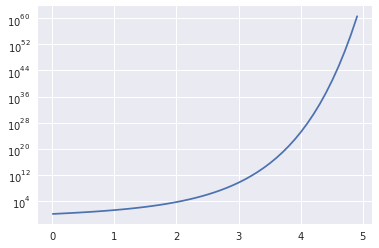

In [32]:
X = np.arange(0.01, 5, 0.1)
c, w = 1.0, -1.0
plt.plot(X, [tf_rmtpp.rmtpp_core.quad_func(t, c, w) / t for t in X])
plt.yscale('log')

In [807]:
data.keys()

dict_keys(['train_event_in_seq', 'train_event_out_seq', 'train_time_in_seq', 'train_time_out_seq', 'test_event_in_seq', 'test_event_out_seq', 'test_time_in_seq', 'test_time_out_seq', 'num_categories'])

In [582]:
tf_rmtpp.utils.MAE(test_time_preds, 
                   data['test_time_out_seq'], 
                   data['test_event_out_seq'])

(0.011261327784789284, 95902)

In [583]:
tf_rmtpp.utils.MAE(train_time_preds, 
                   data['train_time_out_seq'], 
                   data['train_event_out_seq'])

(0.011286010419434762, 377865)

In [584]:
tf_rmtpp.utils.ACC(train_events_preds, 
                   data['train_event_out_seq'])

0.39524697974144207

In [585]:
tf_rmtpp.utils.ACC(test_events_preds, 
                   data['test_event_out_seq'])

0.3879898229442556

In [586]:
tf_rmtpp.utils.data_stats(data)

Num categories =  22
delta-t (training) = 
count    3.778740e+05
mean     1.312461e-02
std      1.652969e-02
min      2.058333e-10
25%      2.613212e-03
50%      7.631856e-03
75%      1.736150e-02
max      3.220176e-01
dtype: float64
base-rate = 76.19273530557021, log(base_rate) = 4.33326612095048
Class probs =  [  6.24255704e-02   1.97711406e-02   6.48364270e-03   4.36052758e-01
   5.75456369e-02   6.17480959e-02   1.94244642e-02   1.92365709e-02
   2.29195446e-01   1.39199839e-02   2.19914575e-03   2.74800595e-02
   8.77805829e-03   1.88898945e-02   3.03011057e-03   9.92394290e-04
   2.77341124e-03   5.37745386e-03   3.75257361e-03   7.14523889e-04
   1.50843932e-04   5.82204650e-05]
delta-t (testing) = 
count    9.590700e+04
mean     1.291405e-02
std      1.646905e-02
min      2.058333e-10
25%      2.424433e-03
50%      7.344151e-03
75%      1.706356e-02
max      2.712632e-01
dtype: float64
base-rate = 77.43506973871634, log(base_rate) = 4.349439775377487
Class probs =  [  6.2466764

22

In [ ]:
from IPython.core.debugger import Pdb
pdb = Pdb()

In [ ]:
rmtpp_mdl.sess.run(tf.nn.softplus(rmtpp_mdl.wt))

In [ ]:
tf_rmtpp.rmtpp_core.softplus(rmtpp_mdl.sess.run(rmtpp_mdl.wt))

In [168]:
pdb.runcall(rmtpp_mdl.predict_train, data=data, single_threaded=True)

> /home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py(574)predict_train()
    572     def predict_train(self, data, single_threaded=False):
    573         """Make (time, event) predictions on the training data."""
--> 574         return self.predict(event_in_seq=data['train_event_in_seq'],
    575                             time_in_seq=data['train_time_in_seq'],
    576                             single_threaded=single_threaded)

ipdb> until 551
*** "until" line number is smaller than current line number
ipdb> s
> /home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py(575)predict_train()
    572     def predict_train(self, data, single_threaded=False):
    573         """Make (time, event) predictions on the training data."""
    574         return self.predict(event_in_seq=data['train_event_in_seq'],
--> 575                             time_in_seq=data['train_time_in_seq'],
    576                             single_threaded=single_threaded)

ipdb> s
> /home/utkarshu

ipdb> s
> /home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py(549)_quad_worker()
    547             idx, h_i = params
    548             preds_i = []
--> 549             C = np.exp(np.dot(h_i, Vt) + bt).reshape(-1)
    550 
    551             for c_, t_last in zip(C, time_in_seq[:, idx]):

ipdb> n
> /home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py(551)_quad_worker()
    549             C = np.exp(np.dot(h_i, Vt) + bt).reshape(-1)
    550 
--> 551             for c_, t_last in zip(C, time_in_seq[:, idx]):
    552                 args = (c_, wt)
    553                 val, _err = quad(quad_func, 0, np.inf, args=args)

ipdb> C
array([  1.97831831e+15,   1.97831831e+15,   1.97831831e+15,
         1.97831831e+15,   1.97831831e+15,   1.97831831e+15,
         1.97831831e+15,   1.97831831e+15,   1.97831831e+15,
         1.97831831e+15,   1.97831831e+15,   1.97831831e+15,
         1.97831831e+15,   1.97831831e+15,   1.97831831e+15,
         1.97831831e+15,   1.97831831e

ipdb> print(bt)
[[ 35.22102356]]
ipdb> n
> /home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py(552)_quad_worker()
    550 
    551             for c_, t_last in zip(C, time_in_seq[:, idx]):
--> 552                 args = (c_, wt)
    553                 val, _err = quad(quad_func, 0, np.inf, args=args)
    554                 preds_i.append(t_last + val)

ipdb> n
> /home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py(553)_quad_worker()
    551             for c_, t_last in zip(C, time_in_seq[:, idx]):
    552                 args = (c_, wt)
--> 553                 val, _err = quad(quad_func, 0, np.inf, args=args)
    554                 preds_i.append(t_last + val)
    555 

ipdb> args
params = (0, array([[  7.13341343e-16,   7.04132930e-16,   7.11919598e-16, ...,
          7.10254067e-16,   7.03531484e-16,   7.04990339e-16],
       [  7.07047941e-16,   6.97918091e-16,   7.05635990e-16, ...,
          7.03985176e-16,   6.97321991e-16,   6.98767930e-16],
       [  7.007

/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:40: RuntimeWarning: invalid value encountered in multiply
  return c * t * np.exp(-w * t - (c / w) * (np.exp(-w * t) - 1))


array([[ nan]], dtype=float32)
ipdb> quad_func(100, c_, wt)


/home/utkarshu/prog/work/tf_rmtpp/src/tf_rmtpp/rmtpp_core.py:40: RuntimeWarning: overflow encountered in exp
  return c * t * np.exp(-w * t - (c / w) * (np.exp(-w * t) - 1))


array([[ inf]], dtype=float32)
ipdb> np.exp(-wt * 100)
array([[ 0.99999923]], dtype=float32)
ipdb> -wt * t - (c_ / wt) * (np.exp(-wt * t) - 1)
*** NameError: name 't' is not defined
ipdb> -wt * 100 - (c_ / wt) * (np.exp(-wt * 100) - 1)
array([[  1.94058992e+17]], dtype=float32)
ipdb> quit


In [556]:
time_preds.shape

(1990, 100, 1999)

In [562]:
data['test_time_out_seq'].shape

(100, 1999)

In [538]:
len(time_preds)

1990

In [537]:
len(time_preds[0][0])

1999

In [527]:
time_preds.shape

AttributeError: 'list' object has no attribute 'shape'

In [526]:
rmtpp_mdl.sess.run(rmtpp_mdl.wt)

array([[ 0.67356926]], dtype=float32)

In [524]:
np.mean(np.asarray(time_preds).shape)

1363.0

In [ ]:
time_preds

In [ ]:
pd.Series(time_preds)

ValueError: range parameter must be finite.

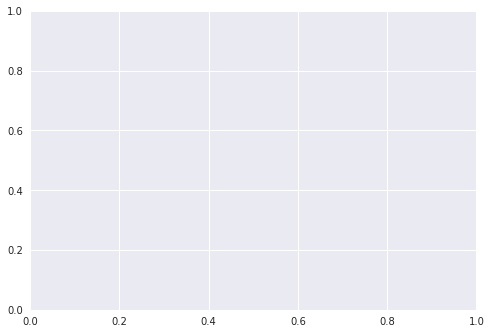

In [511]:
plt.hist(time_preds)

In [439]:
%%time
rmtpp_mdl.train(training_data=data, restart=True, with_summaries=True, num_epochs=9)

Restoring from ./save.rmtpp/model.ckpt-799
INFO:tensorflow:Restoring parameters from ./save.rmtpp/model.ckpt-799
Starting epoch... 1
Loss during batch 0 last BPTT = 3892142519466590208.000, lr = 0.08622
Loss on last epoch = 3892142519466590208.0000, new lr = 0.08622, global_step = 1598
Starting epoch... 2
Loss during batch 0 last BPTT = 4477427402338729984.000, lr = 0.08066
Loss on last epoch = 4477427402338729984.0000, new lr = 0.08066, global_step = 2397
Starting epoch... 3
Loss during batch 0 last BPTT = 3853046085006131200.000, lr = 0.07578
Loss on last epoch = 3853046085006131200.0000, new lr = 0.07578, global_step = 3196
Starting epoch... 4
Loss during batch 0 last BPTT = 3826016240904699904.000, lr = 0.07145
Loss on last epoch = 3826016240904699904.0000, new lr = 0.07145, global_step = 3995
Starting epoch... 5
Loss during batch 0 last BPTT = 3895325055873187840.000, lr = 0.06759
Loss on last epoch = 3895325055873187840.0000, new lr = 0.06759, global_step = 4794
Starting epoch...

In [447]:
len(data['train_event_in_seq']) / rmtpp_mdl.BATCH_SIZE

1.5625

In [446]:
(len(data['train_event_in_seq'][0]) / rmtpp_mdl.BPTT)

799.9

In [445]:
(len(data['train_event_in_seq'][0])) #  / rmtpp_mdl.BATCH_SIZE) / rmtpp_mdl.BPTT

7999

In [227]:
data['train_time_in_seq'][[2, 3], :][:, 4] - data['train_time_in_seq'][[2, 3], :][:, 3]

array([ 0.00921901,  0.00011524])

In [166]:
data['train_time_in_seq'][[0, 1], :]

array([[ 0.05606906,  0.05609789,  0.12283624, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03780895,  0.05659572,  0.0711524 , ...,  0.        ,
         0.        ,  0.        ]])

In [167]:
data['train_time_out_seq'][[0, 1], :]

array([[ 0.05609789,  0.12283624,  0.12970529, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05659572,  0.0711524 ,  0.09084344, ...,  0.        ,
         0.        ,  0.        ]])

In [157]:
len(data['train_time_in_seq'][2])

719

In [152]:
np.max(data['train_time_in_seq'])

0.99998044189529367

In [153]:
np.max(data['test_time_in_seq'])

0.99920974436497556

In [87]:
len(data['test_event_in_seq'])

1326

In [83]:
rmtpp_mdl.BPTT

10

In [86]:
len(h_preds), len(events_preds[0])

(730, 1326)

In [96]:
events_preds[29][10]

array([ 0. ,  0.2,  0. ,  0. ,  0.2,  0.2,  0.2,  0. ,  0. ,  0.2,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ], dtype=float32)

In [95]:
events_preds[0][100]

array([ 0. ,  0.2,  0. ,  0. ,  0.2,  0.2,  0.2,  0. ,  0. ,  0.2,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ], dtype=float32)

In [117]:
iterSession.run(rmtpp_mdl.learning_rate)

4.273139e-06

In [22]:
def foo(n, p):
    return np.exp((1 - p + np.log(p)) / n)

/home/utkarshu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


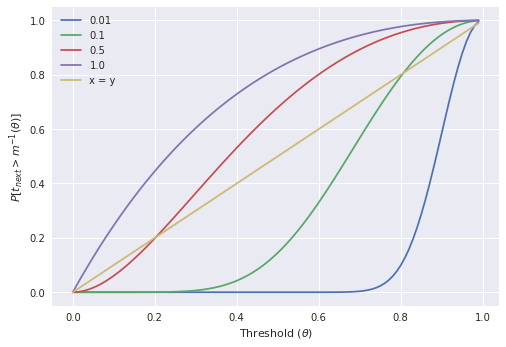

In [29]:
p = np.arange(0, 1, 0.01)
plt.plot(p, foo(0.01, p), label='0.01')
plt.plot(p, foo(0.1, p), label='0.1')
plt.plot(p, foo(0.5, p), label='0.5')
plt.plot(p, foo(1.0, p), label='1.0')
# plt.plot(p, foo(2.0, p), label='2.0')
plt.plot(p, p, label='x = y')
plt.ylabel(r'$P[t_{next} > m^{-1}(\theta)]$')
plt.xlabel(r'Threshold ($\theta$)')
plt.legend()

### Soft-min

In [883]:
def soft_min(x):
    """Provides a soft version of the function min(1, x)."""
    return (np.exp(2.1 * x) - 1)/(np.exp(2.1 * x) + 1)

def hard_min(x):
    return np.minimum(x, 1)

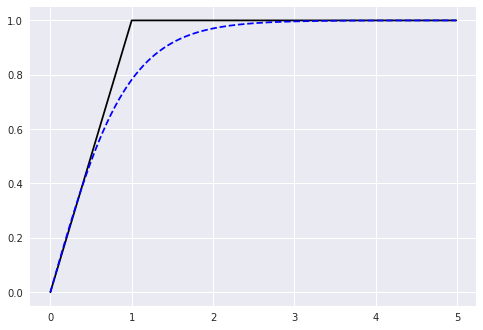

In [884]:
x = np.arange(0, 5, 0.01)
y_hard = hard_min(x)
y_soft = soft_min(x)
plt.plot(x, y_hard, 'k')
plt.plot(x, y_soft, '--b')

In [868]:
hard_min(np.arange(0, 2, 0.1))

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ])

In [885]:
soft_min(np.arange(0, 2, 0.1))

array([ 0.        ,  0.10461582,  0.2069665 ,  0.30497892,  0.39693043,
        0.4815498 ,  0.55805222,  0.62611477,  0.68580906,  0.73751106,
        0.78180636,  0.81940371,  0.85106411,  0.87754767,  0.89957745,
        0.91781744,  0.93286155,  0.94523038,  0.95537312,  0.96367262])